In [2]:
import time
import socket
import random
import threading
import matplotlib.pyplot as plt

In [3]:
class RPL(threading.Thread):
    
    transfer_loss = {"send":0.005,"receive":0.002}
    transfer_threshold = {"send": 1.5, "receive": 0.5}
    metric = {'dist':-1,'rank': -0.50,'power':0.50}
    ATTEMPT_TIME = 1
    MAX_ATTEMPT = 10
    INF = 999
    BEST_PATH_WAIT_TIME = 1

    def __init__(self,addr,coor):
        super(RPL,self).__init__()
        self.addr = addr
        self.coor = coor #[x,y]
        self.node_id = "%s:%s"%addr
        self.dis_id = 0
        self.dag_id = 0
        self.power = 5
        self.rank = None
        self.dist = None
        self.sent_bytes = 0
        self.received_bytes = 0
        self.dis_id_list = {}
        self.parents = {}
        self.childs = {}
        self.timers = {}
        self.best_parent = {} #{'node_id':node_id,'score':score}
        self.msg_box = {}
        self.pending_msg_q = {}
        self.sock = socket.socket()
        self.sock.bind(addr)
        self.sock.listen(5)

    def connect(self,nodes):
        if not isinstance(nodes,list):
            nodes = [nodes]
        for node in nodes:
            s = socket.socket()
            s.connect(node)
            s.send(self.node_id.encode())
            self.parents['%s:%s'%node] = s
            threading.Thread(target=self.listener,args=(s,)).start()

    def max_byte(self,operation):
        avail_pow = self.power-self.transfer_threshold[operation]
        byte = avail_pow/self.transfer_loss[operation]
        return int(byte)

    def power_loss(self,message,op):
        loss = len(message)*self.transfer_loss[op]
        return loss

    def readline(self,sock):
        try:
            data = sock.recv(1)
            while b'\r\n' not in data:
                data += sock.recv(1)
            return data.decode()
        except:
            return ''

    def listener(self,sock):
        while True:
            message = self.readline(sock)
            if message:
                if message[:4] == 'USER':
                    if len(message)<=self.max_byte('receive'):
                        print('Received %s bytes'%len(message))
                        # Update params
                        self.received_bytes += len(message)
                        self.power -= self.power_loss(message,'receive')
                        self.on_recv(message)
                    else:
                        print('Low power')
                else:
                    self.on_recv(message)

    def on_recv(self,message):
        message = message.split('|')
        # Process message
        switch = {'DIS':self.process_dis,
                  'DIO':self.process_dio,
                  'USER': self.process_msg}
        switch[message[0]](message)

    def send(self,sock,message):
        if message[:4] != 'USER':
            # send message
            sock.send(message.encode())
        else:
            if len(message)<=self.max_byte('send'):
                # send message
                sock.send(message.encode())
                # Update params
                self.sent_bytes += len(message)
                self.power -= self.power_loss(message,'send')
                print('Sent %s bytes'%len(message))
            else:
                print('Low power',self.power)

    def distance(self,coor):
        dx = float(coor[0])-self.coor[0]
        dy = float(coor[1])-self.coor[1]
        return (dx**2+dy**2)**0.5
    
    def set_best_parent(self,sink):
        self.best_parent[sink]['is_best'] = 1

    def send_dis(self,dest):
        self.dis_id += 1
        message = 'DIS|%s|%s|%s|\r\n'%(self.dis_id,self.node_id,dest)
        for parent in self.parents:
            self.send(self.parents[parent],message)

    def process_dis(self,message):
        dis_id = message[1]
        orig = message[2]
        dest = message[3]
        if self.node_id == orig:
            return
        if orig in self.dis_id_list:
            # Discard duplicate dis mesage
            if self.dis_id_list[orig] == dis_id:
                return
        # Buffer dis id
        self.dis_id_list[orig] = dis_id

        if self.node_id == dest:
            # send dio
            self.send_dio()
        else :
            self.forward_dis(message)

    def forward_dis(self,message):
        message = '|'.join(message)
        for parent in self.parents:
            self.send(self.parents[parent],message)

    def send_dio(self,dag_id=None,orig=None,rank=0,dist=0,power=None):
        if not rank:self.dag_id += 1
        dag_id = dag_id or self.dag_id
        orig = orig or self.node_id
        self.rank = rank # rank from sink
        self.dist = dist # distance from sink
        power = power or self.INF
        message = 'DIO|%s|%s|%s|%s,%s|%s|%s|%s|\r\n'%(dag_id,orig,self.node_id,*self.coor,self.rank,self.dist,power)
        for node in self.childs:
            self.send(self.childs[node],message)

    def process_dio(self,message):
        # return if current node is sink
        if self.rank==0:return

        dag_id = message[1]
        orig = message[2]
        sender = message[3]
        coor = message[4].split(',')
        rank = int(message[5])+1
        dist = float(message[6])+self.distance(coor)
        power = min(float(message[7]),self.power)

        score = self.obj_func({'dist':dist,'power':power,'rank':rank})

        if orig not in self.best_parent:
            self.best_parent[orig] = {'dag_id':dag_id,'node_id':sender,'score':score,'is_best':0}
        elif self.best_parent[orig]['dag_id'] < dag_id:
            # Update best parent for current dag
            self.best_parent[orig] = {'dag_id':dag_id,'node_id':sender,'score':score,'is_best':0}
        elif self.best_parent[orig]['score'] < score:
            # Update best parent
            self.best_parent[orig] = {'dag_id':dag_id,'node_id':sender,'score':score,'is_best':0}
        else:
            return
        # Send DIO if best parent updated
        self.send_dio(dag_id,orig,rank,dist,power)
        # Restart timer on getiing rreq
        if orig in self.timers:
            # Cancel previous timer
            self.timers[orig].cancel()
        # Add timer
        self.timers[orig] = threading.Timer(self.BEST_PATH_WAIT_TIME,self.set_best_parent,[orig,])
        self.timers[orig].start()

    def obj_func(self,dictionary):
        score = 0
        for key in dictionary:
            if key in self.metric:
                score += dictionary[key]*self.metric[key]
            else:
                score += dictionary[key]
        return score

    def send_msg(self,dest,msg_data):
        message = 'USER|%s|%s|%s|\r\n'%(self.node_id,dest,msg_data)
        self.best_parent.pop(dest,None)
        self.send_dis(dest)
        for _ in range(self.MAX_ATTEMPT):
            if dest in self.best_parent:
                # Wait until finding the best path
                while True:
                    if self.best_parent[dest]['is_best']:
                        best_parent = self.best_parent[dest]['node_id']
                        self.send(self.parents[best_parent],message)
                        # send pending msg if available
                        if self.pending_msg_q:
                            self.send_pending_msgs(dest)
                        return
            else:
                time.sleep(self.ATTEMPT_TIME)
        self.pending_msg_q[dest] = {'orig':self.node_id,'msg_data':msg_data}

    def send_pending_msgs(self,dest):
        if dest in self.best_parent:
            for dest in list(self.pending_msg_q):
                msg = self.pending_msg_q.pop(dest)
                orig = msg['orig']
                msg_data = msg['msg_data']
                message = 'USER|%s|%s|%s|\r\n'%(orig,dest,msg_data)
                best_parent = self.best_parent[dest]['node_id']
                self.send(self.parents[best_parent],message)

    def process_msg(self,message):
        orig = message[1]
        dest = message[2]
        msg_data = message[3]
        if self.node_id == dest:
            self.msg_box[orig] = msg_data
            print('New message arrived')
        else:
            self.forward_msg(message)

    def forward_msg(self,message):
        orig = message[1]
        dest = message[2]
        msg_data = message[3]
        message = '|'.join(message)

        if dest in self.best_parent:
            best_parent = self.best_parent[dest]['node_id']
            self.send(self.parents[best_parent],message)
        else:
            self.pending_msg_q[dest] = {'orig':orig,'msg_data':msg_data}

    def run(self):
        while True:
            try:
                conn , _ = self.sock.accept()
                self.childs[conn.recv(21).decode()] = conn
                threading.Thread(target=self.listener,args=(conn,)).start()
            except:
                print('Connection closed\n')
                break

In [4]:
class Node(RPL):
    def __init__(self,addr,dist_range=[1,50]):
        coor = [random.randint(*dist_range), random.randint(*dist_range)]
        super(Node,self).__init__(addr,coor)

In [5]:
class Network:
    ATTEMPT_TIME = 2
    MAX_ATTEMPT = 10

    def __init__(self,no_of_node,ip='127.0.0.1',start_port=8000):
        self.no_of_node = no_of_node
        self.nodes = {}
        for i in range(no_of_node):
            addr = (ip,start_port+i)
            self.nodes['%s:%s'%addr] = Node(addr)
            self.nodes['%s:%s'%addr].start()
        # Initilize neighbour
        self.init_neighbour()

    def init_neighbour(self):
        for node in self.nodes:
            self.nodes[node].parents = {}
            self.nodes[node].childs = {}
        for node1 in self.nodes:
            for node2 in self.nodes:
                if self.nodes[node1].distance(self.nodes[node2].coor) <= self.nodes[node1].power**2 and node1 != node2:
                    self.nodes[node2].connect(self.nodes[node1].addr)

    def shutdown(self):
        for node in self.nodes.values():
            node.sock.close()
            for parent in node.parents.values():
                parent.close()

    def reset(self,factor):
        for node in self.nodes:
            self.nodes[node].metric = {'dist':-1,'rank': -1+factor,'power':factor}
            self.nodes[node].power = 5
            self.nodes[node].rank = None
            self.nodes[node].dist = None
            self.dis_id = 0
            self.dag_id = 0
            self.nodes[node].sent_bytes = 0
            self.nodes[node].received_bytes = 0
            self.nodes[node].best_parent = {}
            self.nodes[node].msg_box = {}
            self.nodes[node].pending_msg_q = {}

    def plot_transfer_stat(self,dest):
        transfer = []
        power = []
        for i in [0.0,0.2,0.4,0.6,0.8,1.0]:
            total = 0
            self.reset(i)               
            self.start_season(dest)
            for name,node in self.nodes.items():
                total += node.received_bytes+node.sent_bytes
            transfer.append(total/self.no_of_node)
            power.append(i)
        plt.plot(power,transfer)
        plt.show()
  
    def plot_neighbour_connection(self):
        for node in self.nodes:
            for child in self.nodes[node].childs:
                x = [self.nodes[node].coor[0],self.nodes[child].coor[0]]
                y = [self.nodes[node].coor[1],self.nodes[child].coor[1]]
                plt.plot(x, y, '-o')

    def plot_dest_connection(self,dest):
        self.nodes[dest].send_dio()
        for node in self.nodes.values():
            for _ in range(self.MAX_ATTEMPT):
                if dest in node.best_parent:
                    best_parent = self.nodes[node.best_parent[dest]['node_id']]
                    x = [best_parent.coor[0],node.coor[0]]
                    y = [best_parent.coor[1],node.coor[1]]
                    plt.plot(x, y, '-o')
                    break
                time.sleep(self.ATTEMPT_TIME)

    def plot_network(self):
        x=[]
        y=[]
        c=[]
        s=[]
        plt.figure(figsize=(30,15),dpi=200)
        for node in self.nodes.values():
            x.append(node.coor[0])
            y.append(node.coor[1])
            c.append(node.power)
            s.append(3.14*25**2) # mult 8.1
            plt.text(x[-1], y[-1],node.node_id,size=20,horizontalalignment='center',verticalalignment='center',bbox=dict(facecolor='red', alpha=0.4))
        plt.scatter(x, y, s=s, c=c, alpha=0.6,picker=True)
        plt.grid(True)

    def start_season(self,dest):
        for node in self.nodes:
            if node != dest:
                self.init_neighbour()
                self.nodes[node].send_msg(dest,'PING')
                # Check whether msg reaches to dest
                for _ in range(self.MAX_ATTEMPT):
                    if node in self.nodes[dest].msg_box:
                        break
                    time.sleep(self.ATTEMPT_TIME)

In [6]:
try:network.shutdown()
except:pass
network = Network(10)

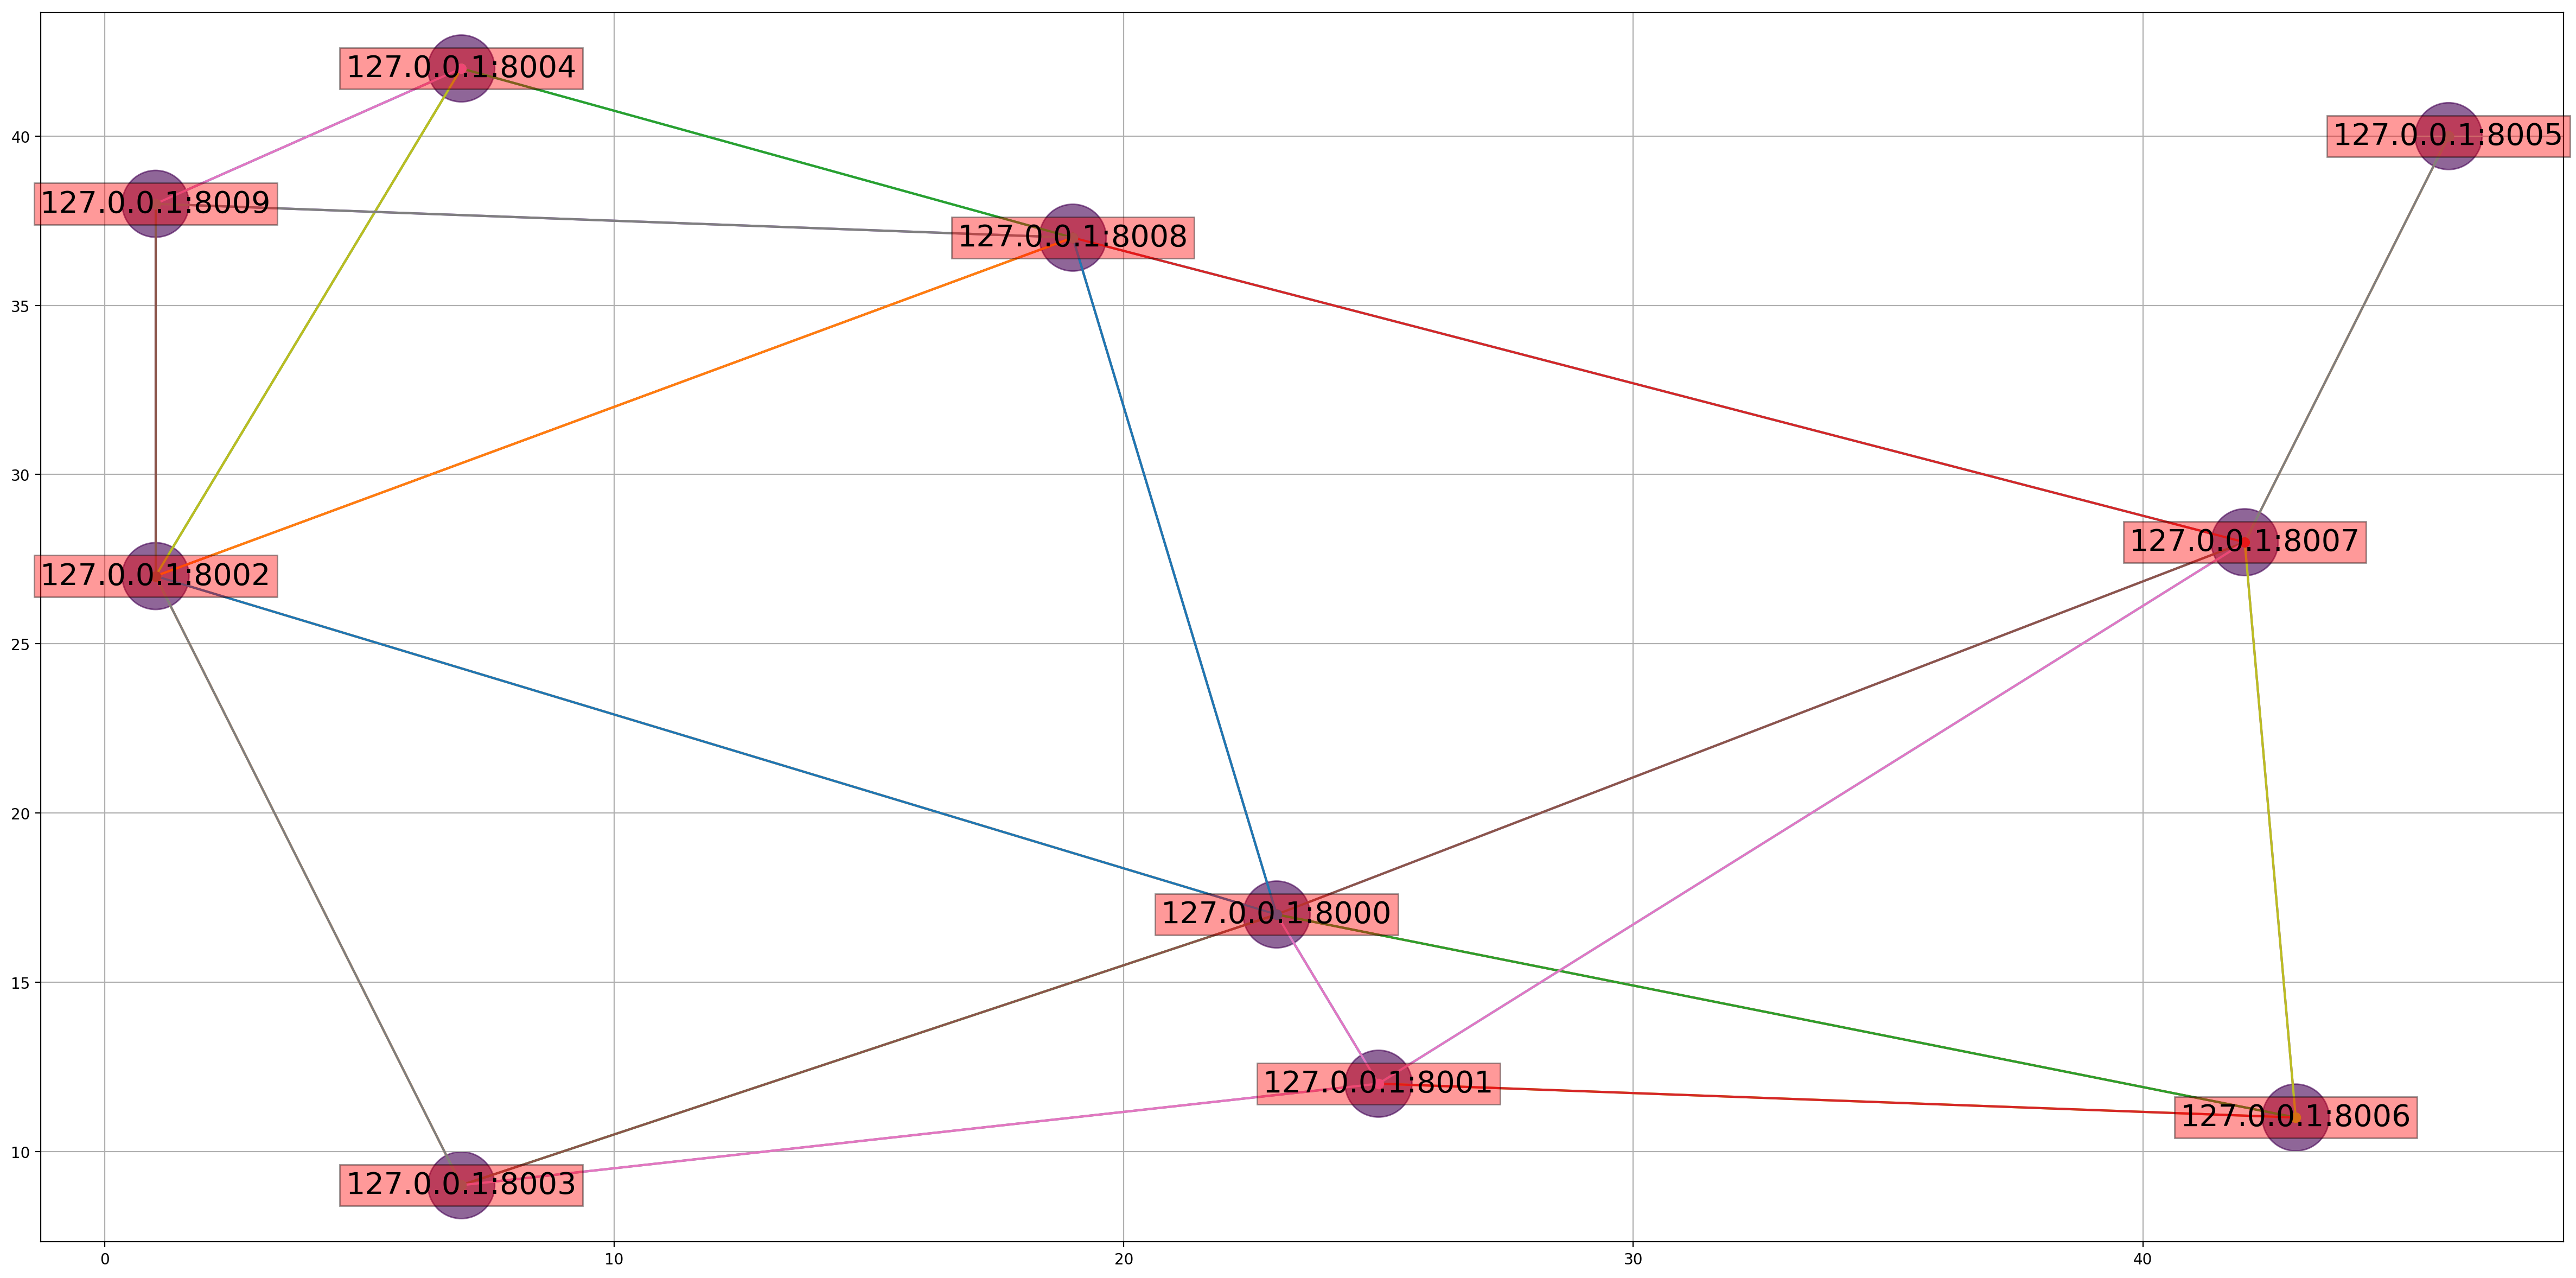

In [7]:
network.plot_network()
network.plot_neighbour_connection()

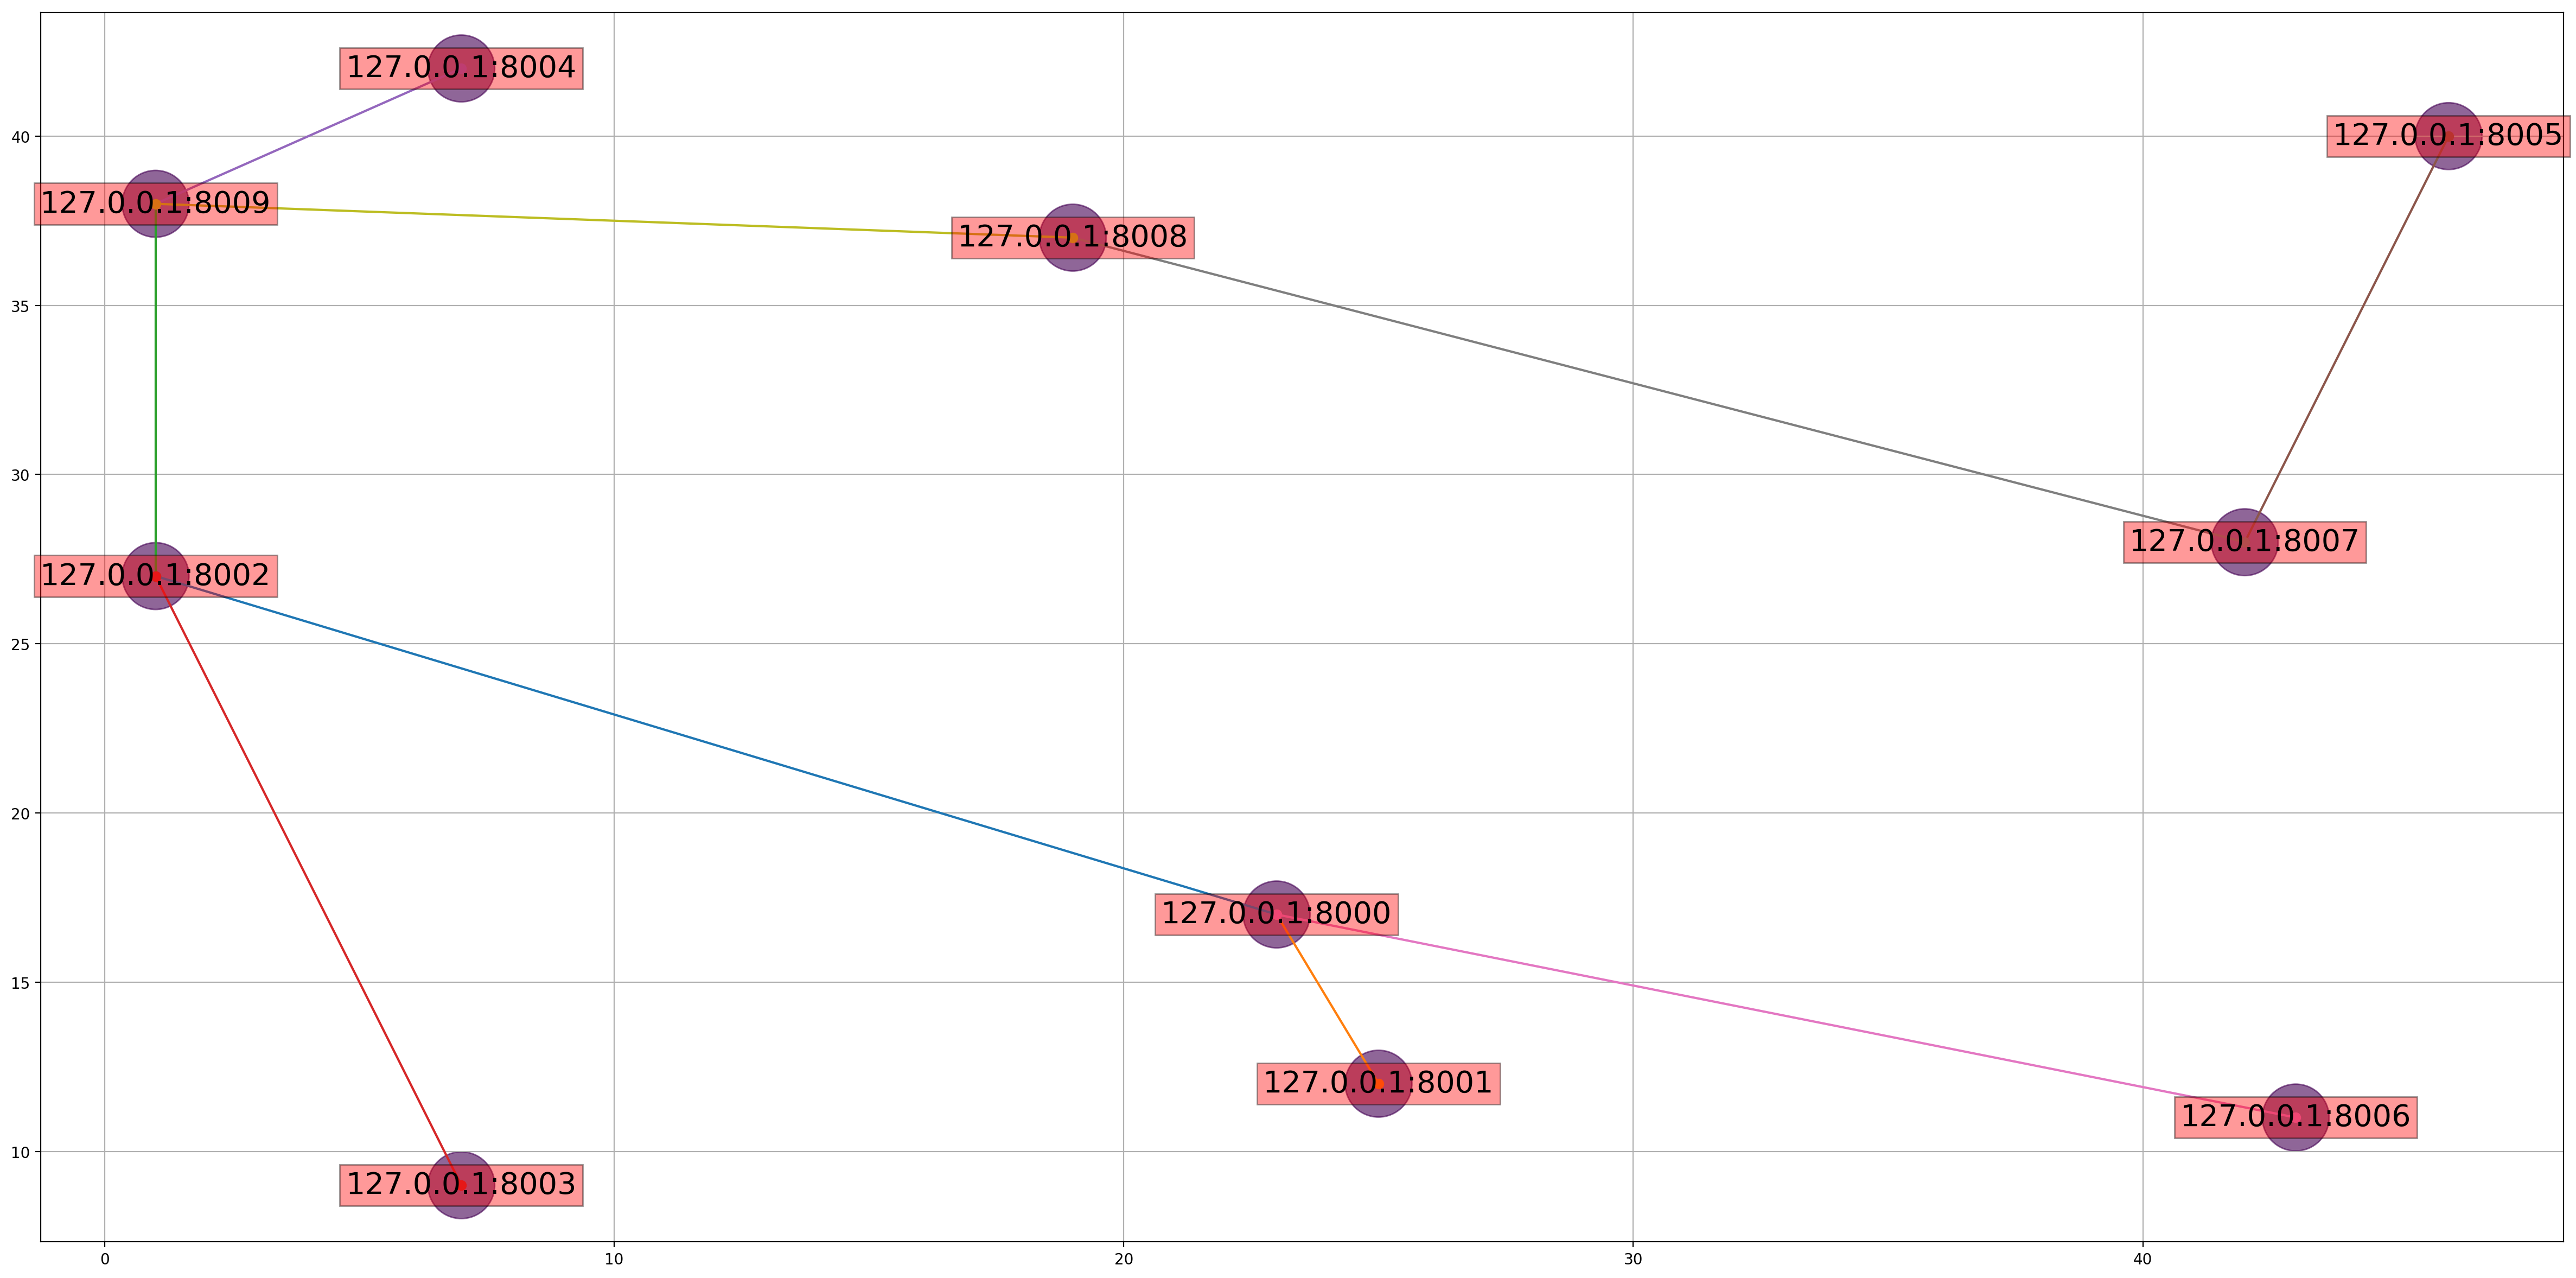

In [8]:
network.plot_network()
network.plot_dest_connection('127.0.0.1:8009')

In [ ]:
network.plot_transfer_stat('127.0.0.1:8009')

In [ ]:
network.nodes['127.0.0.1:8009'].msg_box

In [ ]:
network.plot_transfer_stat('127.0.0.1:8009')

In [ ]:
network.reset(0.0)